# Crucible 4: h_mean Autocorrelation Over 5000 Steps

**Purpose:** Visualize the full 5000-step h_mean autocorrelation to test the "auction attendee gaining confidence" hypothesis.

**Hypothesis:** As training progresses, h_mean should swing more assertively around its equilibrium direction:
- Early: locks in quickly (autocorr → 1.0)
- Mid: begins experimenting (small swings)
- Late: swings with greater amplitude (min autocorr declines)

**What we're looking for:**
1. Does min autocorrelation decline over time?
2. Does variance increase?
3. Is there long-term structure beyond the 500-step window?

## Setup

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

# Random seed
torch.manual_seed(42)
np.random.seed(42)

# Plot styling
STEELBLUE = '#4682B4'
CORAL = '#ff6b6b'
plt.rcParams['figure.dpi'] = 200

## Load Data

In [4]:
PROJECT_ROOT = Path.cwd().parent.parent.parent.parent
DATA_PATH = PROJECT_ROOT / 'box_4' / 'tensors' / 'Crucible-4' / 'crucible_4_trajectory.safetensors'

print(f"Loading data from {DATA_PATH}")
data = load_file(str(DATA_PATH))

h_mean = data['h_mean'].float()  # (5000, 64)
loss = data['loss'].float()  # (5001,)

n_steps = h_mean.shape[0]
print(f"\nLoaded h_mean: {h_mean.shape}")
print(f"Steps: {n_steps}")

Loading data from /Users/jefferyharrell/Projects/Azimuth_II/box_4/tensors/Crucible-4/crucible_4_trajectory.safetensors

Loaded h_mean: torch.Size([5000, 64])
Steps: 5000


## Compute Autocorrelation

In [5]:
def cosine_similarity(a, b):
    """Cosine similarity between two vectors."""
    return torch.dot(a, b) / (torch.norm(a) * torch.norm(b))

# Compute step-to-step autocorrelation
h_autocorr = torch.zeros(n_steps - 1)
for t in range(n_steps - 1):
    h_autocorr[t] = cosine_similarity(h_mean[t], h_mean[t+1])

print(f"Autocorrelation computed: {h_autocorr.shape}")
print(f"\nFull 5000-step statistics:")
print(f"  Mean: {h_autocorr.mean():.6f}")
print(f"  Std:  {h_autocorr.std():.6f}")
print(f"  Min:  {h_autocorr.min():.6f}")
print(f"  Max:  {h_autocorr.max():.6f}")

Autocorrelation computed: torch.Size([4999])

Full 5000-step statistics:
  Mean: 0.997927
  Std:  0.005334
  Min:  0.631758
  Max:  0.999984


## Plot: Full 5000-Step Autocorrelation (Raw)

No smoothing. Show me da noiz.

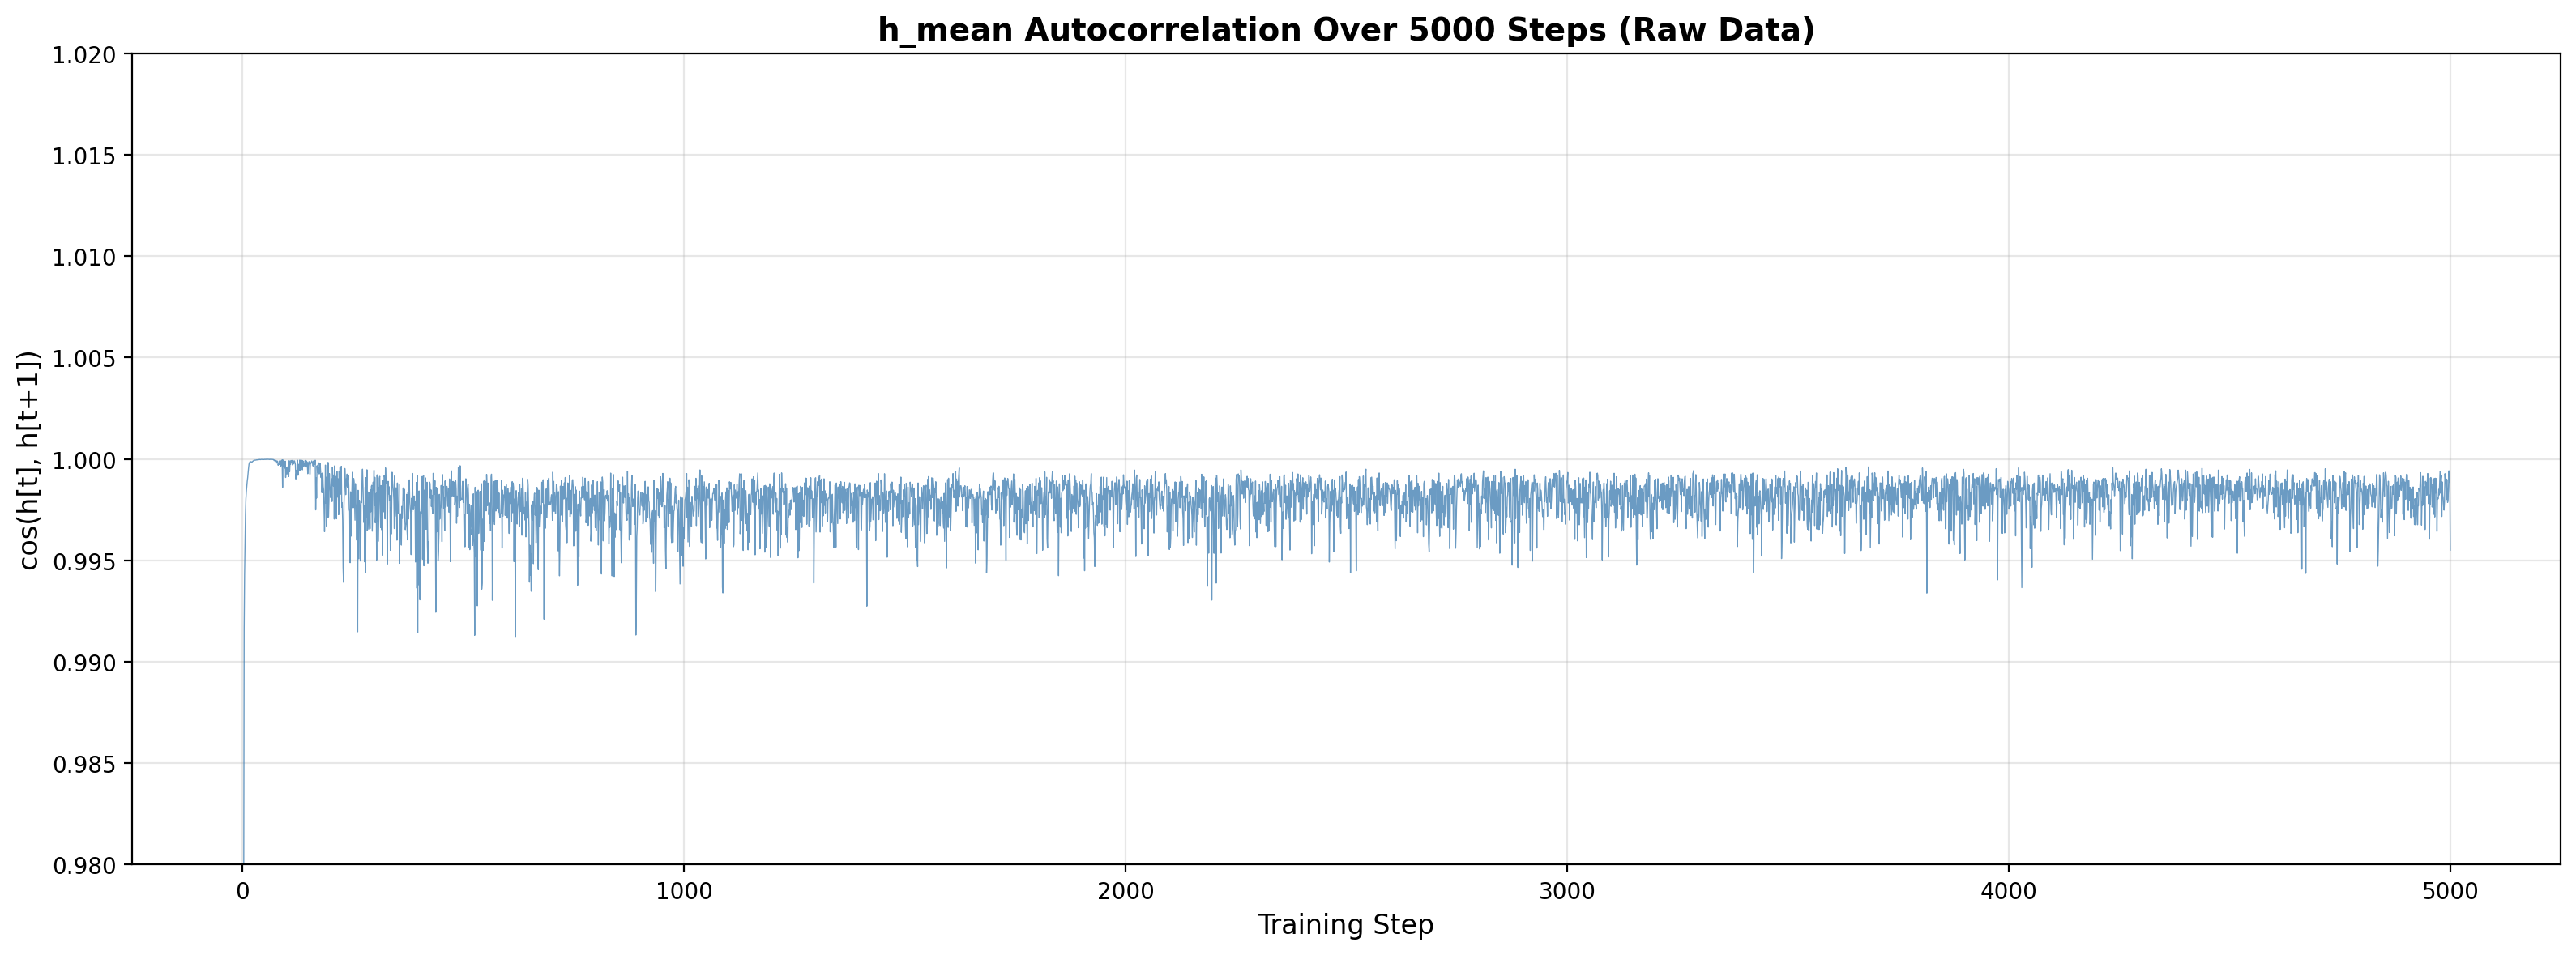

In [56]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(range(1, n_steps), h_autocorr.detach().numpy(), 
        color=STEELBLUE, linewidth=0.5, alpha=0.8)

# ax.axhline(y=1, color='red', linestyle='--', alpha=0.3, linewidth=1)
# ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3, linewidth=1)

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('cos(h[t], h[t+1])', fontsize=12)
ax.set_title('h_mean Autocorrelation Over 5000 Steps (Raw Data)', fontsize=14, fontweight='bold')
ax.set_ylim(0.98, 1.02)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Plot: Zoomed to Natural Range

Same data, but y-axis limited to actual range to see fine structure.

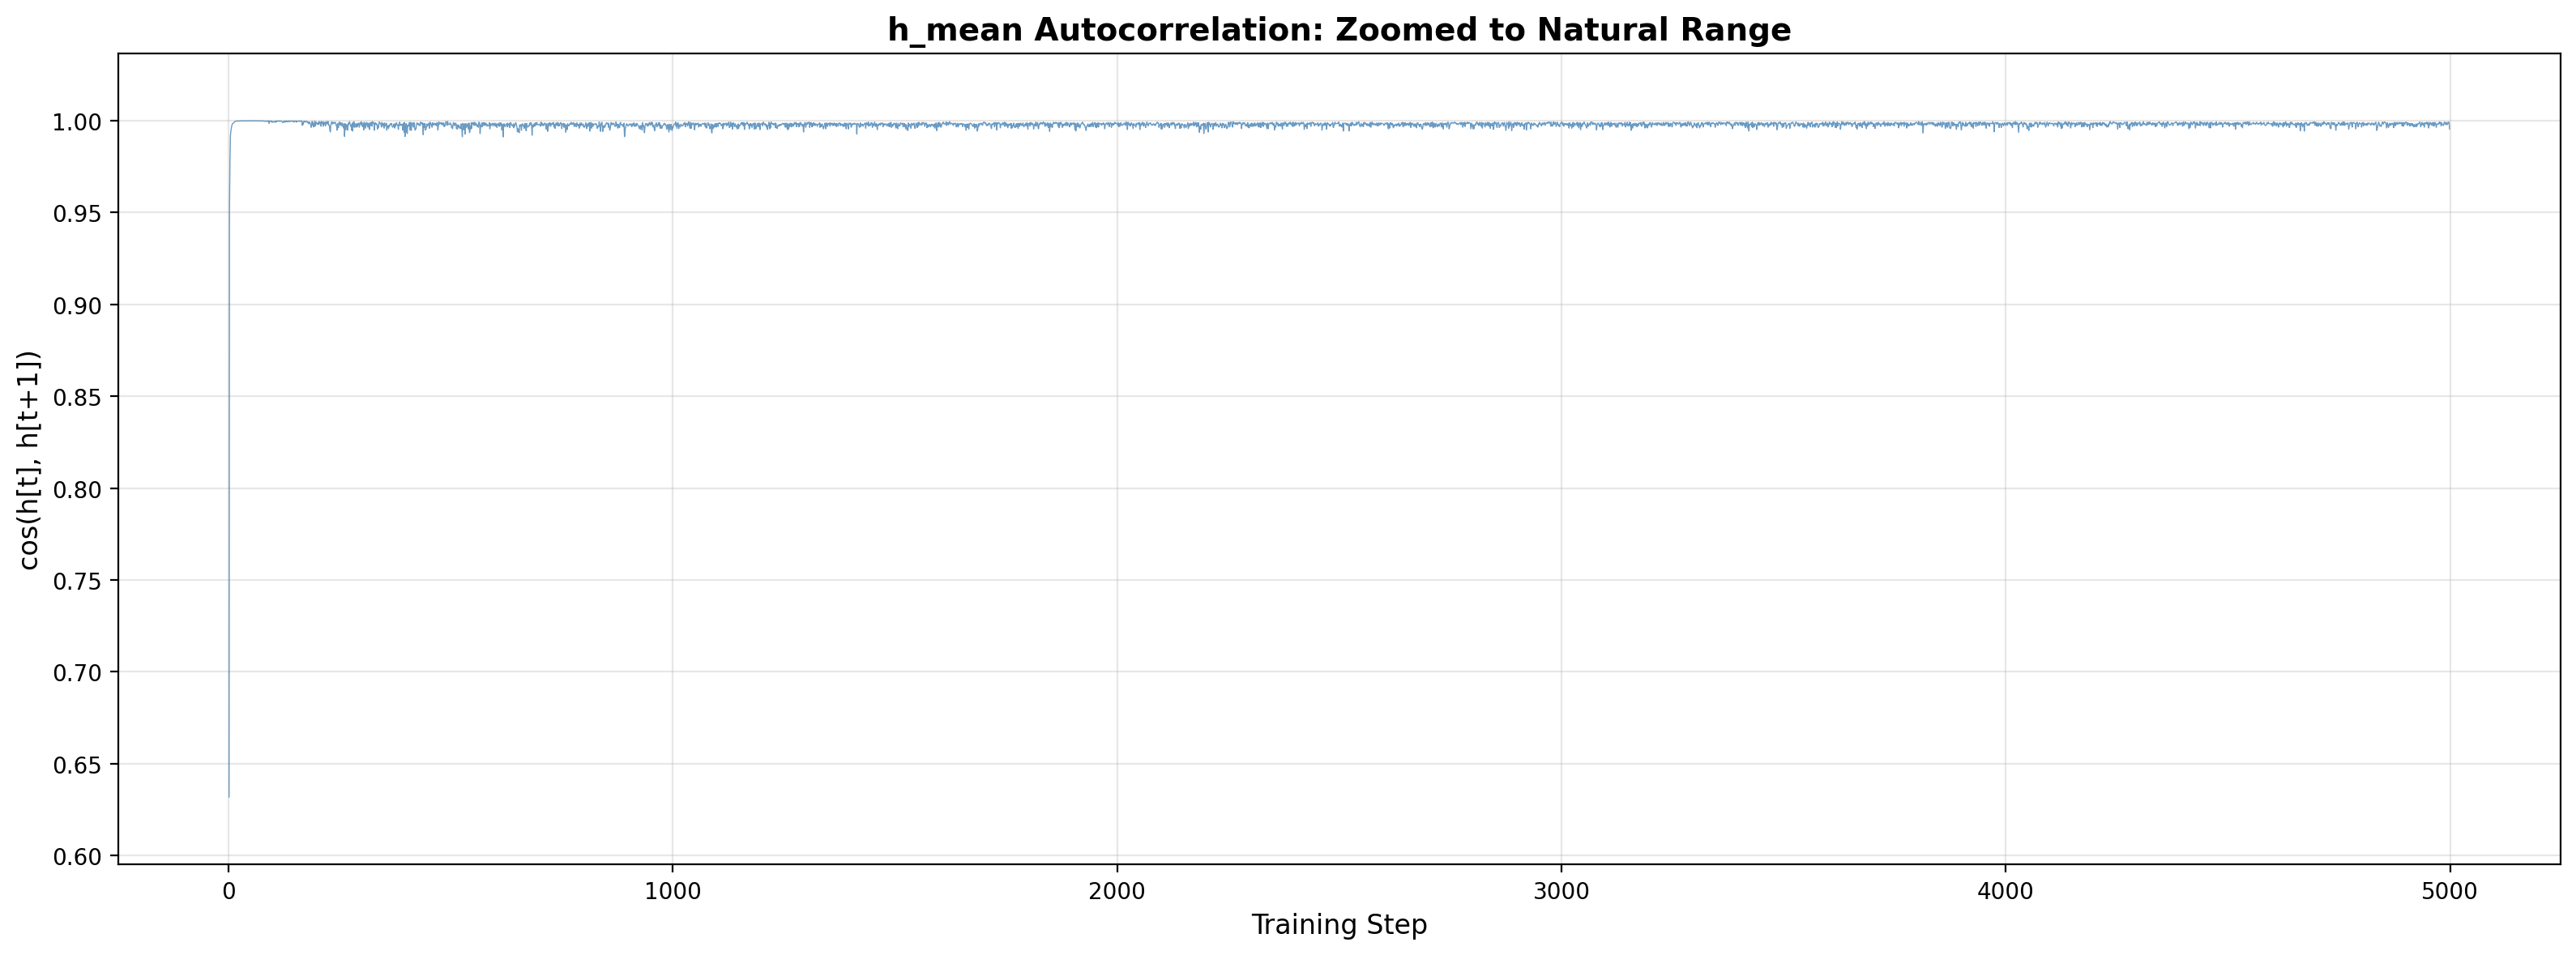

Natural range: [0.631758, 0.999984]


In [57]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(range(1, n_steps), h_autocorr.detach().numpy(), 
        color=STEELBLUE, linewidth=0.5, alpha=0.8)

# Natural y-axis range with padding
y_min = h_autocorr.min().item()
y_max = h_autocorr.max().item()
y_padding = (y_max - y_min) * 0.1
ax.set_ylim(y_min - y_padding, y_max + y_padding)

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('cos(h[t], h[t+1])', fontsize=12)
ax.set_title('h_mean Autocorrelation: Zoomed to Natural Range', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Natural range: [{y_min:.6f}, {y_max:.6f}]")

## Binned Statistics

Break the 5000 steps into bins to see how autocorrelation changes over training phases.

In [58]:
bin_size = 500
n_bins = n_steps // bin_size

bin_means = []
bin_stds = []
bin_mins = []
bin_maxs = []
bin_labels = []

for i in range(n_bins):
    start = i * bin_size
    end = (i + 1) * bin_size
    
    bin_data = h_autocorr[start:min(end-1, len(h_autocorr))]
    
    bin_means.append(bin_data.mean().item())
    bin_stds.append(bin_data.std().item())
    bin_mins.append(bin_data.min().item())
    bin_maxs.append(bin_data.max().item())
    bin_labels.append(f'{start}-{end-1}')

print("h_mean autocorrelation by 500-step bins:")
print("\n" + "="*80)
print(f"{'Bin':<15} {'Mean':<12} {'Std':<12} {'Min':<12} {'Max':<12}")
print("="*80)
for i, label in enumerate(bin_labels):
    print(f"{label:<15} {bin_means[i]:<12.6f} {bin_stds[i]:<12.6f} {bin_mins[i]:<12.6f} {bin_maxs[i]:<12.6f}")
print("="*80)

h_mean autocorrelation by 500-step bins:

Bin             Mean         Std          Min          Max         
0-499           0.997557     0.016628     0.631758     0.999984    
500-999         0.997474     0.001314     0.991199     0.999390    
1000-1499       0.997794     0.000992     0.992744     0.999458    
1500-1999       0.997865     0.000981     0.994244     0.999563    
2000-2499       0.997934     0.000969     0.993041     0.999462    
2500-2999       0.998017     0.000904     0.994381     0.999494    
3000-3499       0.998065     0.000877     0.994395     0.999429    
3500-3999       0.998128     0.000912     0.993386     0.999609    
4000-4499       0.998221     0.000855     0.993655     0.999573    
4500-4999       0.998216     0.000832     0.994356     0.999516    


## Plot: Binned Trends

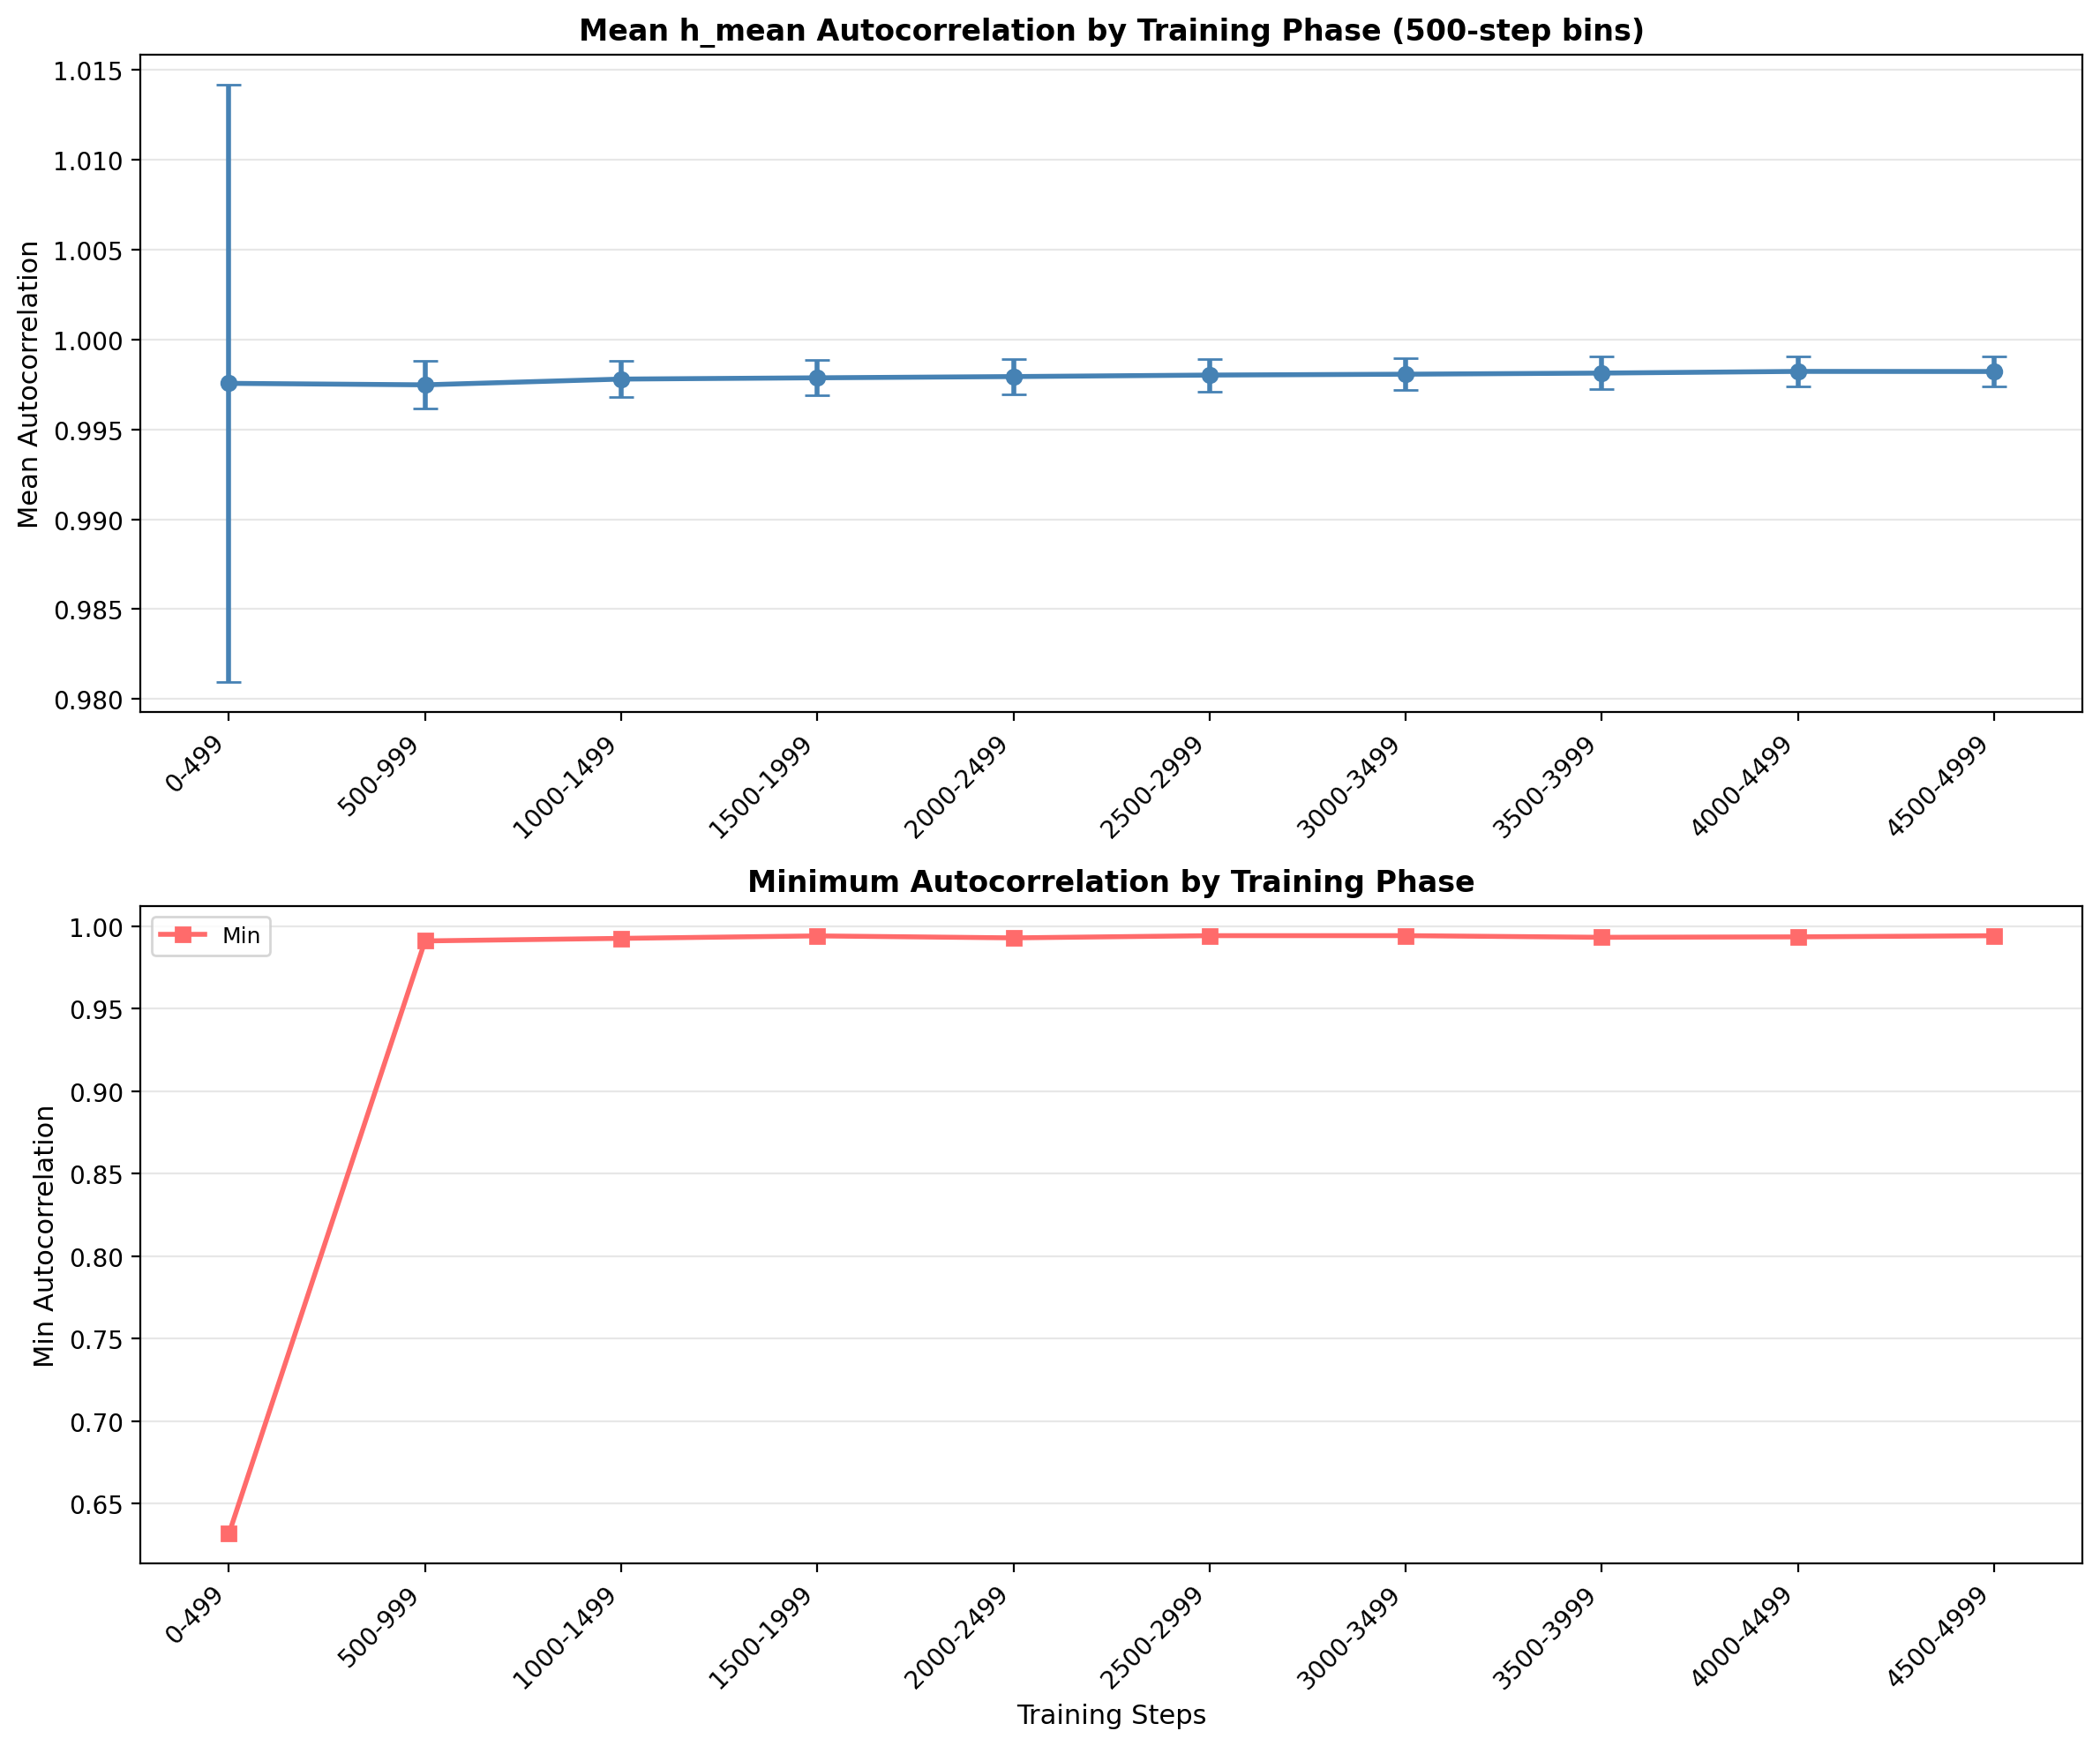

In [59]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

x_pos = np.arange(len(bin_labels))

# Top: Mean with error bars
ax1.errorbar(x_pos, bin_means, yerr=bin_stds, 
             color=STEELBLUE, marker='o', markersize=6, capsize=5, linewidth=2)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(bin_labels, rotation=45, ha='right')
ax1.set_ylabel('Mean Autocorrelation', fontsize=11)
ax1.set_title('Mean h_mean Autocorrelation by Training Phase (500-step bins)', 
              fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Bottom: Min values (testing "declining minimum" hypothesis)
ax2.plot(x_pos, bin_mins, color=CORAL, marker='s', markersize=6, linewidth=2, label='Min')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(bin_labels, rotation=45, ha='right')
ax2.set_xlabel('Training Steps', fontsize=11)
ax2.set_ylabel('Min Autocorrelation', fontsize=11)
ax2.set_title('Minimum Autocorrelation by Training Phase', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.legend(fontsize=9)

plt.tight_layout()
plt.show()

## Histogram: Distribution Over Full Run

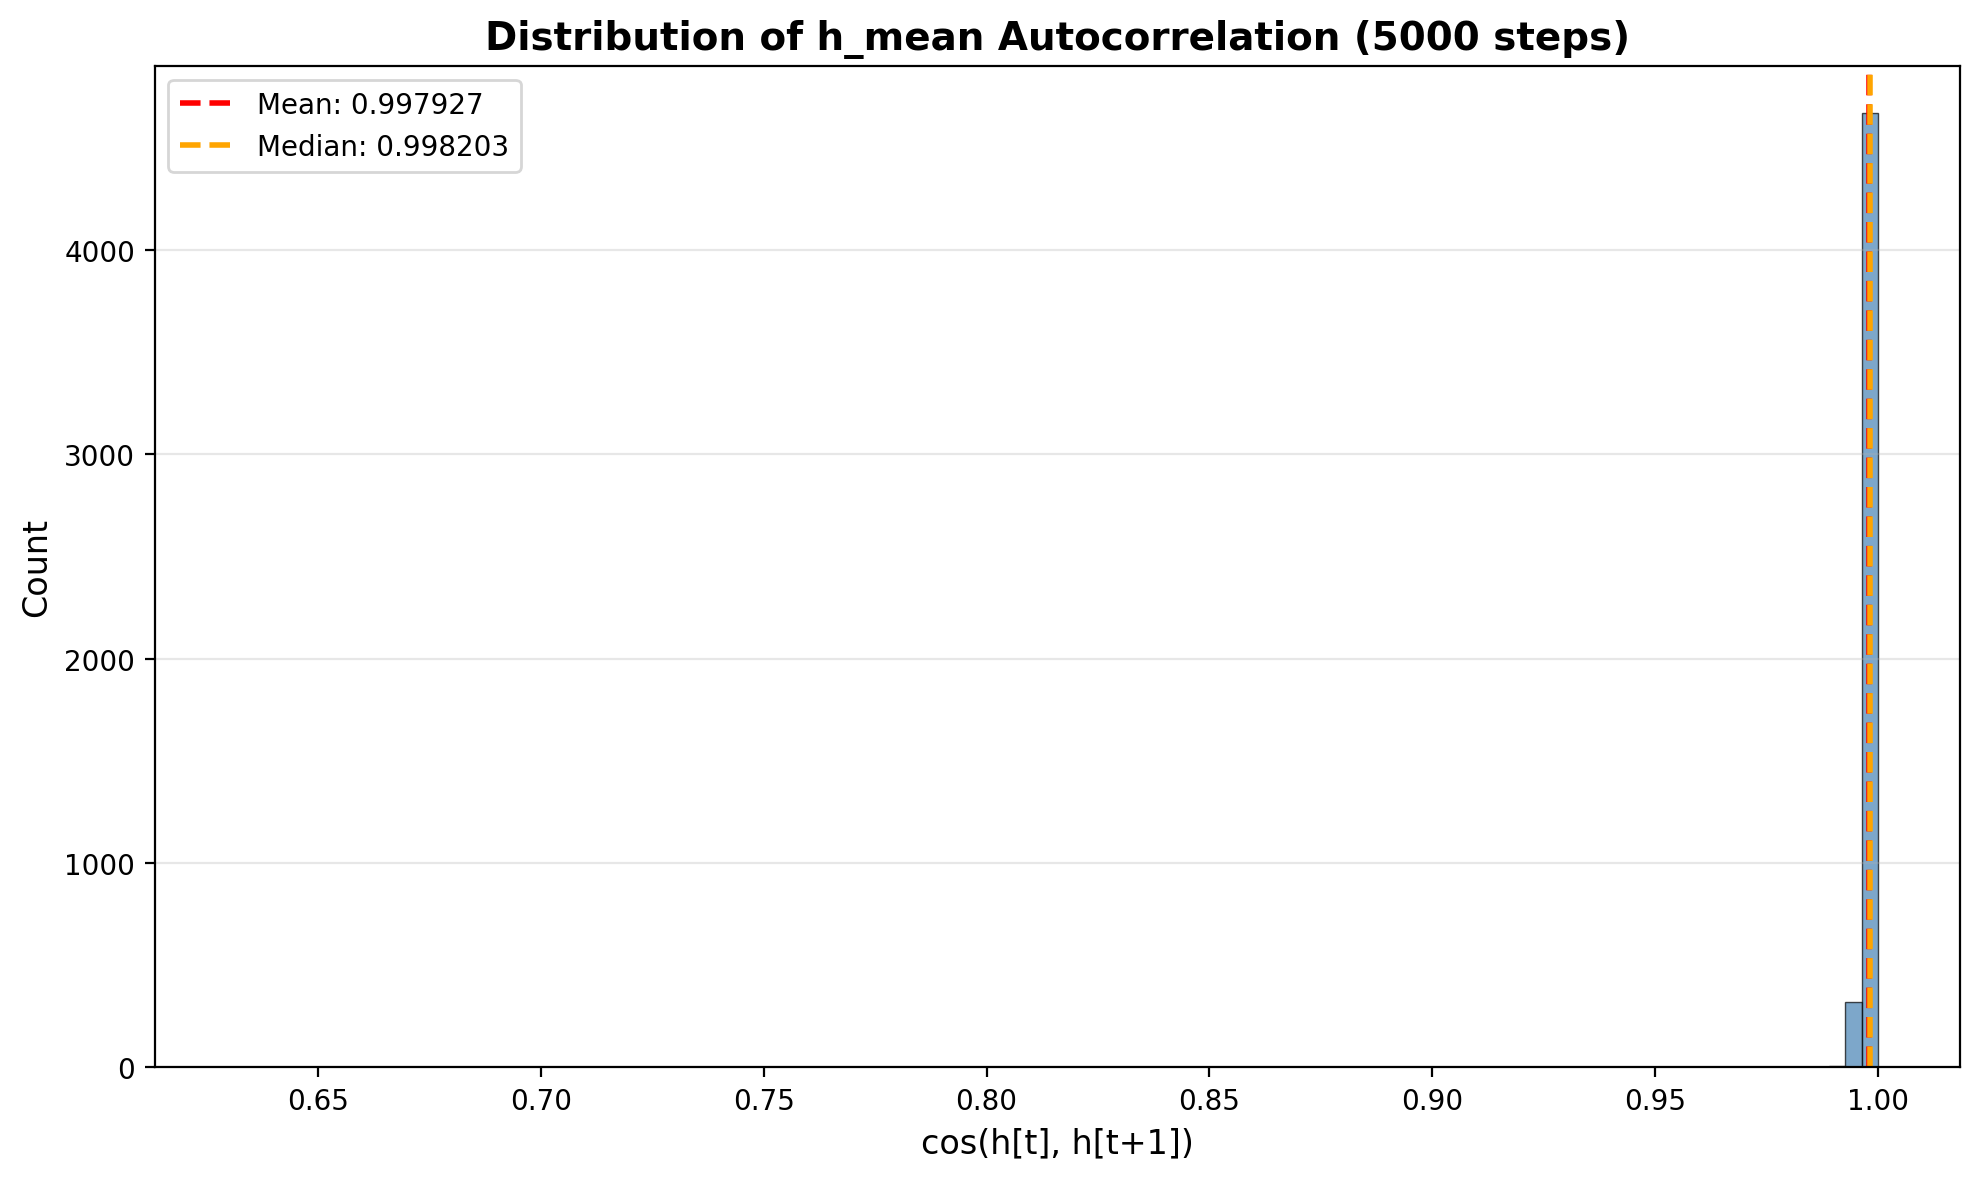

In [60]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(h_autocorr.detach().numpy(), bins=100, color=STEELBLUE, 
        alpha=0.7, edgecolor='black', linewidth=0.5)

ax.axvline(h_autocorr.mean().item(), color='red', linestyle='--', 
           linewidth=2, label=f'Mean: {h_autocorr.mean().item():.6f}')
ax.axvline(h_autocorr.median().item(), color='orange', linestyle='--', 
           linewidth=2, label=f'Median: {h_autocorr.median().item():.6f}')

ax.set_xlabel('cos(h[t], h[t+1])', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of h_mean Autocorrelation (5000 steps)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Loss Curve Context

Plot loss over 5000 steps to see if h_mean behavior correlates with training progress.

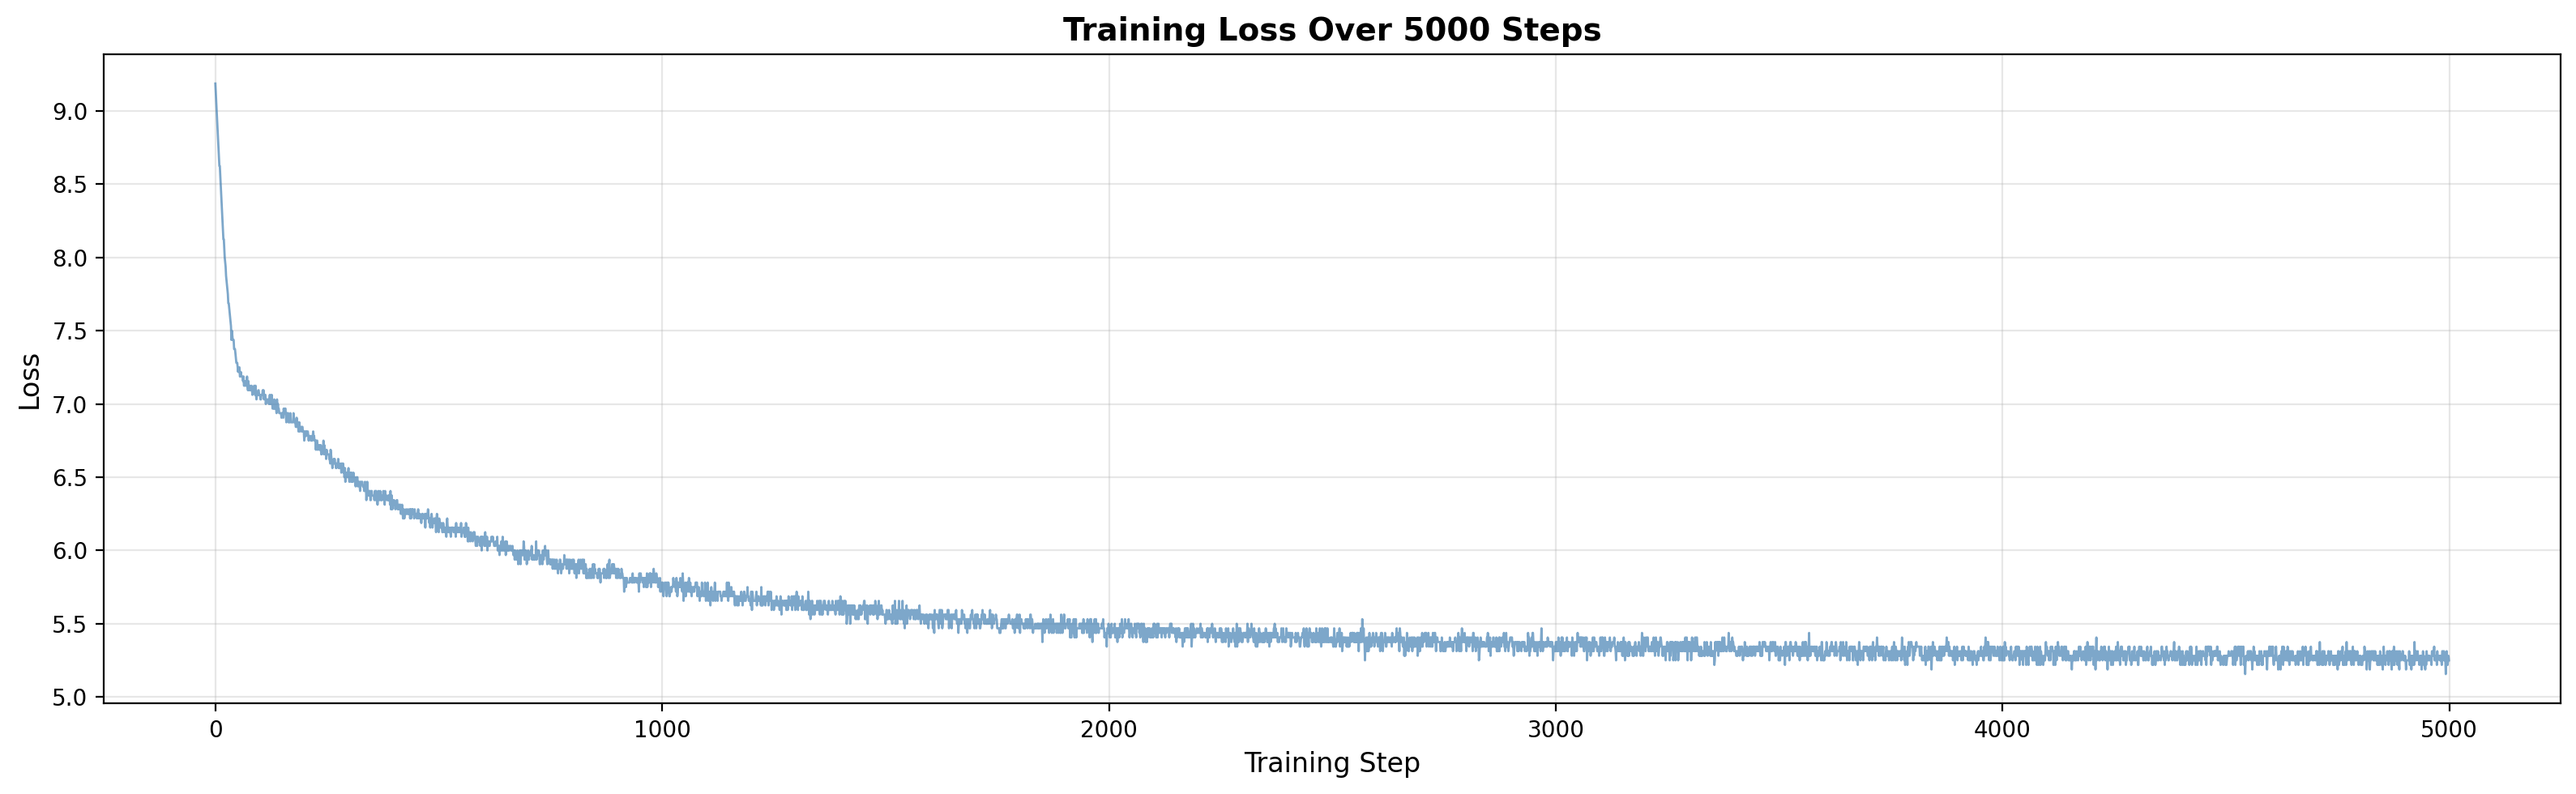

Loss statistics:
  Initial (step 1): 9.1875
  Final (step 5000): 5.2500
  Reduction: 3.9375


In [61]:
fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(loss[1:].numpy(), color=STEELBLUE, linewidth=1, alpha=0.7)

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training Loss Over 5000 Steps', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Loss statistics:")
print(f"  Initial (step 1): {loss[1].item():.4f}")
print(f"  Final (step 5000): {loss[-1].item():.4f}")
print(f"  Reduction: {loss[1].item() - loss[-1].item():.4f}")

## Rolling Statistics

Compute rolling min/max/std over windows to see if swing amplitude changes over time.

In [62]:
window = 100  # Use larger window for 5000 steps
n_windows = n_steps - window

rolling_mean = torch.zeros(n_windows)
rolling_min = torch.zeros(n_windows)
rolling_max = torch.zeros(n_windows)
rolling_std = torch.zeros(n_windows)

for i in range(n_windows):
    window_data = h_autocorr[i:i+window]
    rolling_mean[i] = window_data.mean()
    rolling_min[i] = window_data.min()
    rolling_max[i] = window_data.max()
    rolling_std[i] = window_data.std()

print(f"Computed rolling statistics over {n_windows} windows (window size: {window})")

Computed rolling statistics over 4900 windows (window size: 100)


## Plot: Rolling Min (Testing Hypothesis)

**Hypothesis:** If swing amplitude increases, rolling min should decline over time.

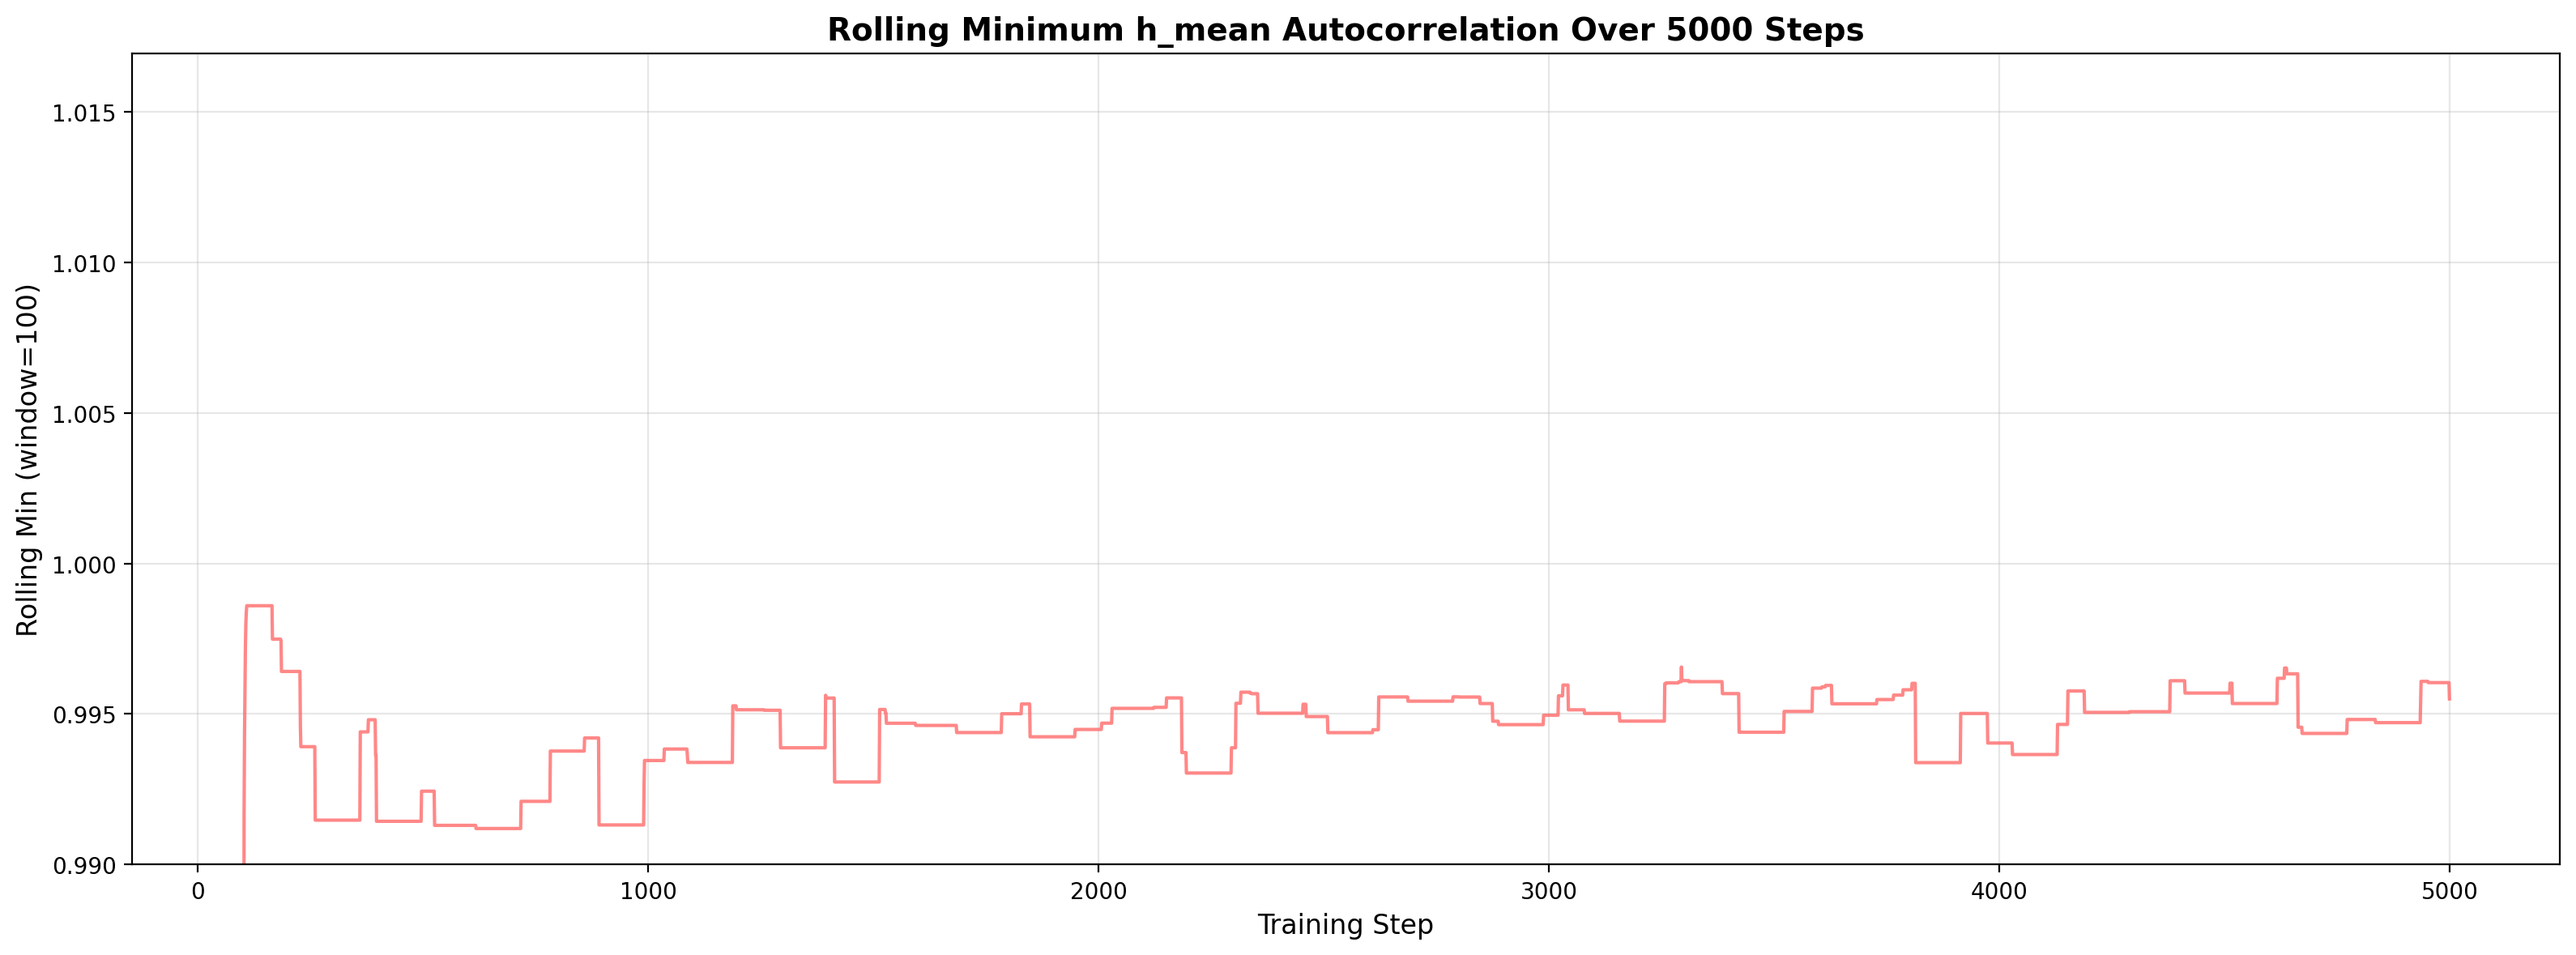


Rolling min trend:
  Early average (steps 100-1100): 0.992517
  Late average (steps 4000-5000): 0.995035
  Change: 0.002518
  Trend: INCREASING


In [69]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(range(window, n_steps), rolling_min.detach().numpy(), 
        color=CORAL, linewidth=1.5, alpha=0.8)

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('Rolling Min (window=100)', fontsize=12)
ax.set_title('Rolling Minimum h_mean Autocorrelation Over 5000 Steps', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

ax.set_ylim(bottom=0.99)

plt.tight_layout()
plt.show()

# Trend analysis
early_min = rolling_min[:1000].mean().item()
late_min = rolling_min[-1000:].mean().item()

print(f"\nRolling min trend:")
print(f"  Early average (steps {window}-{window+1000}): {early_min:.6f}")
print(f"  Late average (steps {n_steps-1000}-{n_steps}): {late_min:.6f}")
print(f"  Change: {late_min - early_min:.6f}")
print(f"  Trend: {'DECLINING' if late_min < early_min else 'INCREASING'}")

## Plot: Rolling Std (Variance Test)

**Hypothesis:** If swings get bigger, variance should increase.

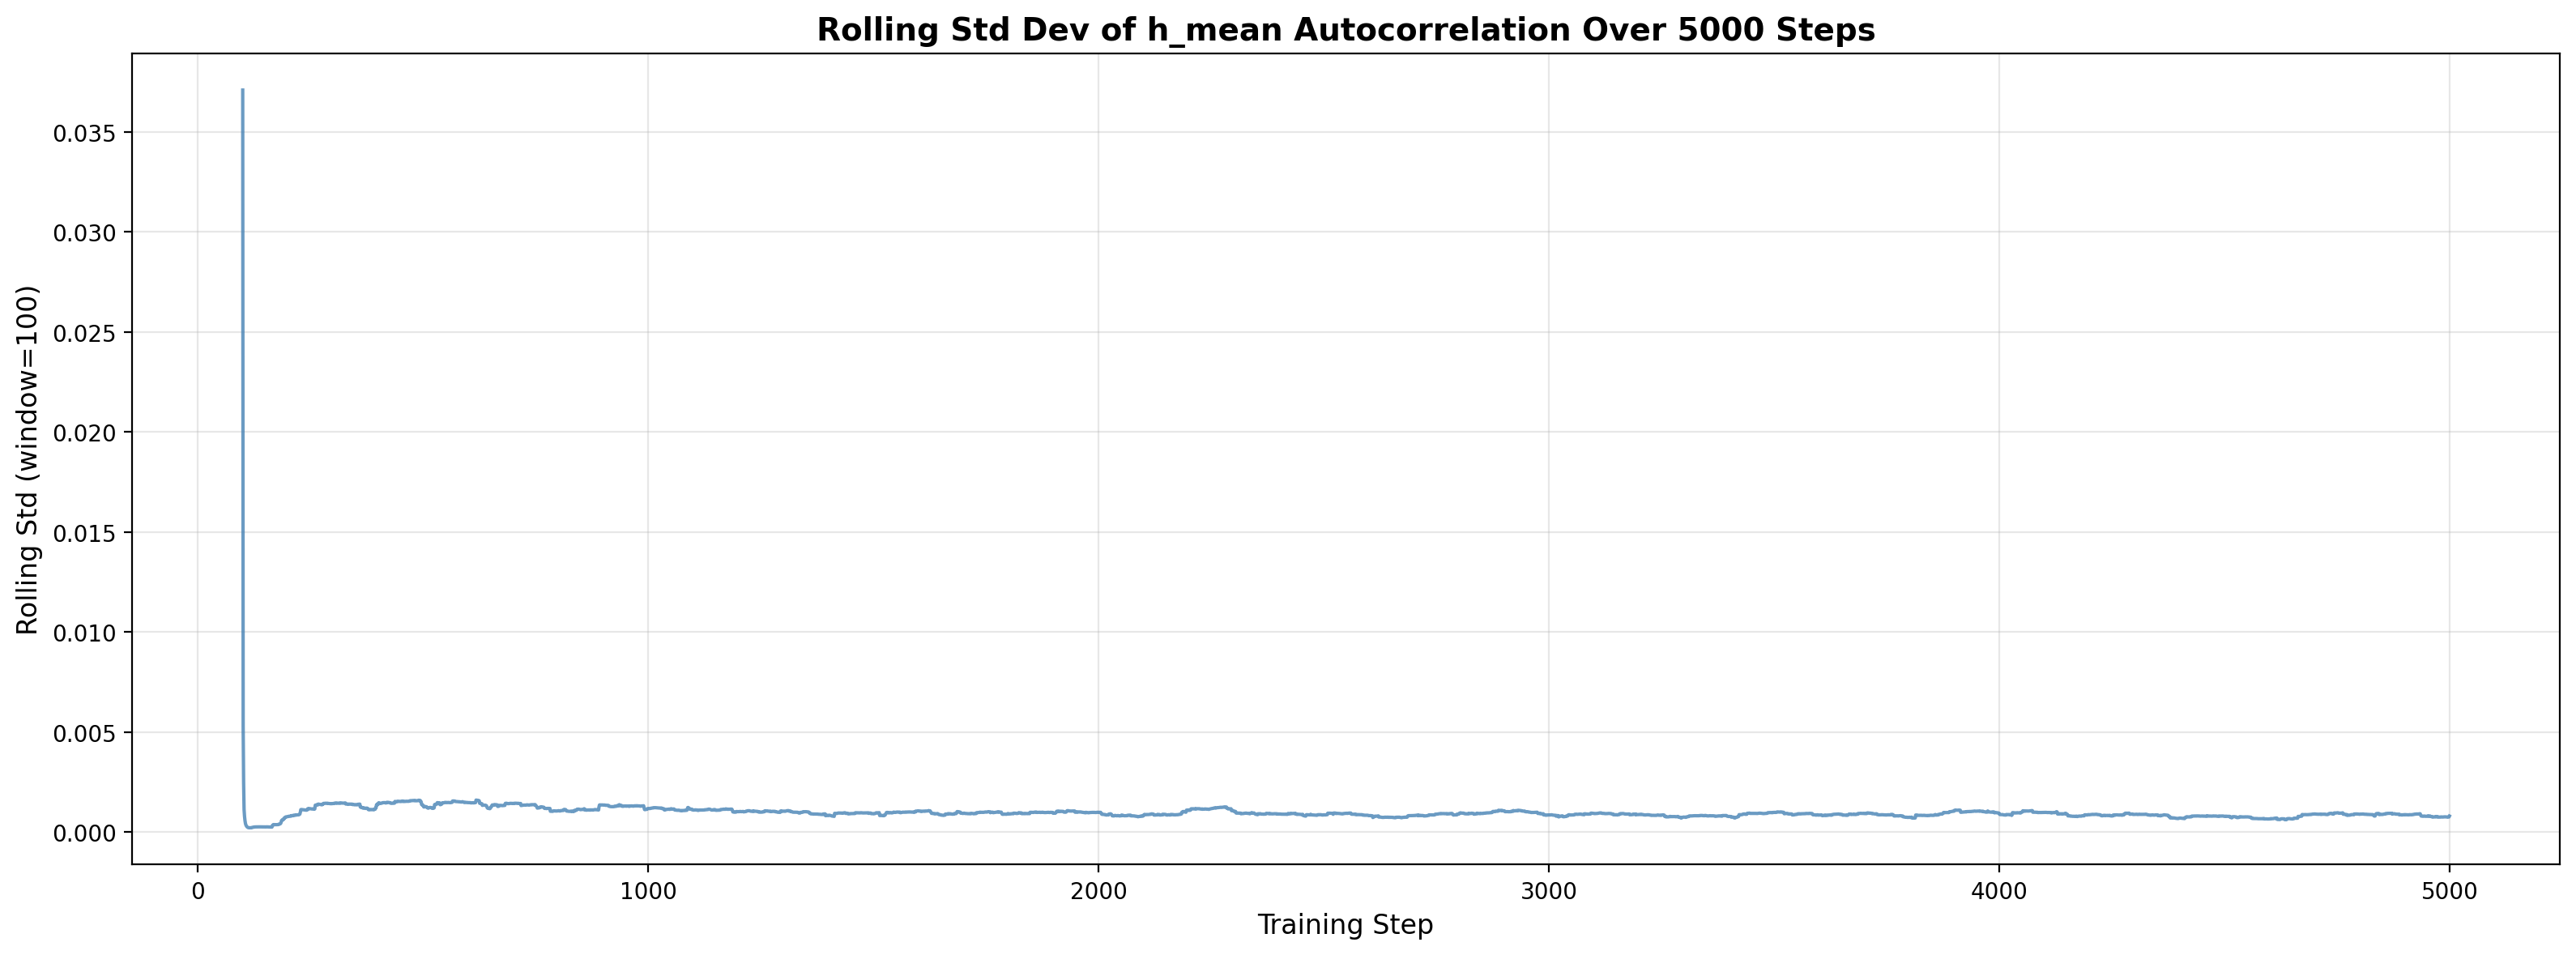


Rolling std trend:
  Early average: 0.001245
  Late average: 0.000841
  Change: -0.000404
  Trend: DECREASING


In [70]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(range(window, n_steps), rolling_std.detach().numpy(), 
        color=STEELBLUE, linewidth=1.5, alpha=0.8)

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('Rolling Std (window=100)', fontsize=12)
ax.set_title('Rolling Std Dev of h_mean Autocorrelation Over 5000 Steps', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Trend analysis
early_std = rolling_std[:1000].mean().item()
late_std = rolling_std[-1000:].mean().item()

print(f"\nRolling std trend:")
print(f"  Early average: {early_std:.6f}")
print(f"  Late average: {late_std:.6f}")
print(f"  Change: {late_std - early_std:.6f}")
print(f"  Trend: {'INCREASING' if late_std > early_std else 'DECREASING'}")

## Summary: Hypothesis Test

In [71]:
print("=" * 70)
print("AUCTION ATTENDEE HYPOTHESIS: 5000-STEP VERDICT")
print("=" * 70)

print("\nPredictions:")
print("  1. Rolling min autocorrelation DECLINES over time")
print("  2. Rolling std autocorrelation INCREASES over time")
print("  3. Swing amplitude grows as model gains confidence")

min_declining = late_min < early_min
std_increasing = late_std > early_std

print("\nObservations:")
print(f"  1. Rolling min trend: {'DECLINING ✓' if min_declining else 'NOT DECLINING ✗'}")
print(f"     (Early: {early_min:.6f}, Late: {late_min:.6f}, Δ: {late_min - early_min:+.6f})")
print(f"  2. Rolling std trend: {'INCREASING ✓' if std_increasing else 'NOT INCREASING ✗'}")
print(f"     (Early: {early_std:.6f}, Late: {late_std:.6f}, Δ: {late_std - early_std:+.6f})")

if min_declining and std_increasing:
    print("\n✅ HYPOTHESIS SUPPORTED")
    print("Both predicted signatures present. Model appears to swing h_mean")
    print("with increasing amplitude over long training.")
elif min_declining or std_increasing:
    print("\n⚠️  HYPOTHESIS PARTIALLY SUPPORTED")
    print("Some signatures present, but not all. Evidence is mixed.")
else:
    print("\n❌ HYPOTHESIS NOT SUPPORTED")
    print("Predicted signatures absent. h_mean swings do not increase over time.")

print("\n" + "=" * 70)

AUCTION ATTENDEE HYPOTHESIS: 5000-STEP VERDICT

Predictions:
  1. Rolling min autocorrelation DECLINES over time
  2. Rolling std autocorrelation INCREASES over time
  3. Swing amplitude grows as model gains confidence

Observations:
  1. Rolling min trend: NOT DECLINING ✗
     (Early: 0.992517, Late: 0.995035, Δ: +0.002518)
  2. Rolling std trend: NOT INCREASING ✗
     (Early: 0.001245, Late: 0.000841, Δ: -0.000404)

❌ HYPOTHESIS NOT SUPPORTED
Predicted signatures absent. h_mean swings do not increase over time.

